

# Removing muscle ICA components

Gross movements produce widespread high-frequency activity across all channels
that is usually not recoverable and so the epoch must be rejected as shown in
`ex-muscle-artifacts`. More ubiquitously than gross movements, muscle
artifact is produced during postural maintenance. This is more appropriately
removed by ICA otherwise there wouldn't be any epochs left! Note that muscle
artifacts of this kind are much more pronounced in EEG than they are in MEG.


In [ ]:
# Authors: Alex Rockhill <aprockhill@mailbox.org>
#
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [7]:
import mne

data_path = mne.datasets.sample.data_path()
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_fname)
raw.crop(tmin=100, tmax=130)  # take 30 seconds for speed

# pick only EEG channels, muscle artifact is basically not picked up by MEG
# if you have a simultaneous recording, you may want to do ICA on MEG and EEG
# separately
raw.pick(picks="eeg", exclude="bads")

# ICA works best with a highpass filter applied
raw.load_data()
raw.filter(l_freq=1.0, h_freq=None)

Opening raw data file C:\Users\ABC\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Reading 0 ... 18019  =      0.000 ...    30.001 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter lengt

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


<Raw | sample_audvis_raw.fif, 59 x 18020 (30.0 s), ~11.1 MB, data loaded>

Run ICA



In [14]:
import picard
ica = mne.preprocessing.ICA(
    n_components=15, method="picard", max_iter="auto", random_state=97
)
ica.fit(raw)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 1.1s.


<ICA | raw data decomposition, method: picard (fit in 49 iterations on 9760 samples), 15 ICA components (64 PCA components available), channel types: eeg, no sources marked for exclusion>

Remove components with postural muscle artifact using ICA



Creating RawArray with float64 data, n_channels=15, n_times=18020
    Range : 85861 ... 103880 =    142.955 ...   172.956 secs
Ready.


Using matplotlib as 2D backend.


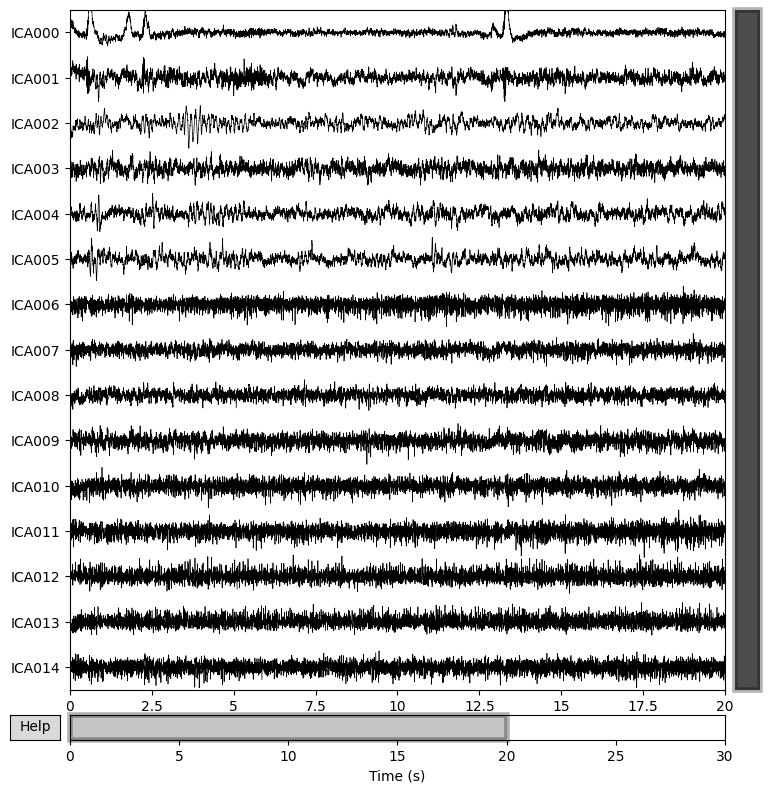

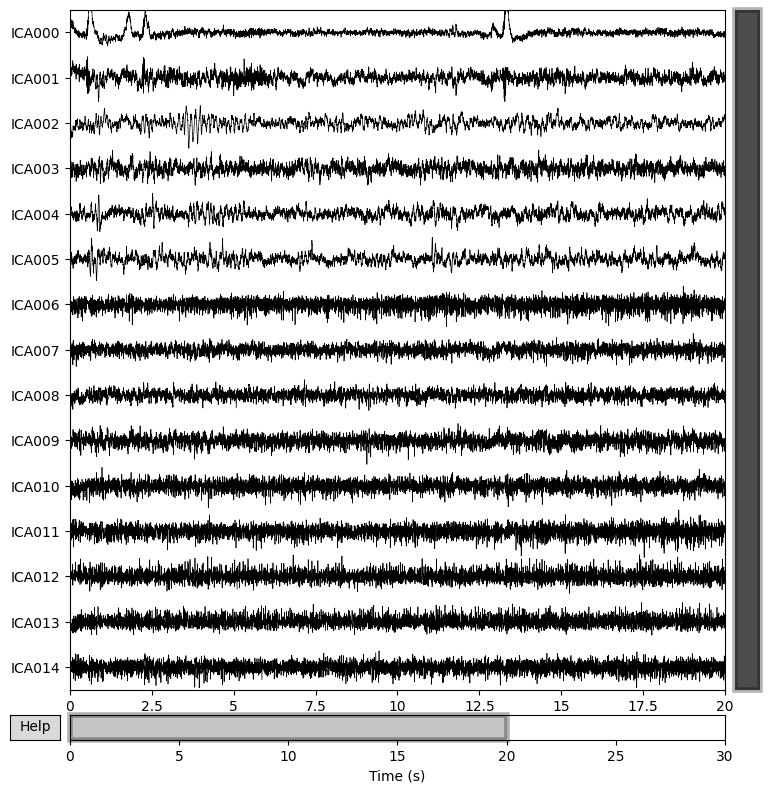

In [9]:
ica.plot_sources(raw)

By inspection, let's select out the muscle-artifact components based on
:footcite:`DharmapraniEtAl2016` manually.

The criteria are:

- Positive slope of log-log power spectrum between 7 and 75 Hz
  (here just flat because it's not in log-log)
- Peripheral focus or dipole/multi-pole foci (the blue and red
  blobs in the topomap are far from the vertex where the most
  muscle is)
- Single focal point (low spatial smoothness; there is just one focus
  of the topomap compared to components like the first ones that are
  more likely neural which spread across the topomap)

The other attribute worth noting is that the time course in
:func:`mne.preprocessing.ICA.plot_sources` looks like EMG; you can
see spikes when each motor unit fires so that the time course looks fuzzy
and sometimes has large spikes that are often at regular intervals.

ICA component 13 is a textbook example of what muscle artifact looks like.
The focus of the topomap for this component is right on the temporalis
muscle near the ears. There is also a minimum in the power spectrum at around
10 Hz, then a maximum at around 25 Hz, generally resulting in a positive
slope in log-log units; this is a very typical pattern for muscle artifact.



    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
15 matching events found
No baseline correction applied
0 projection i

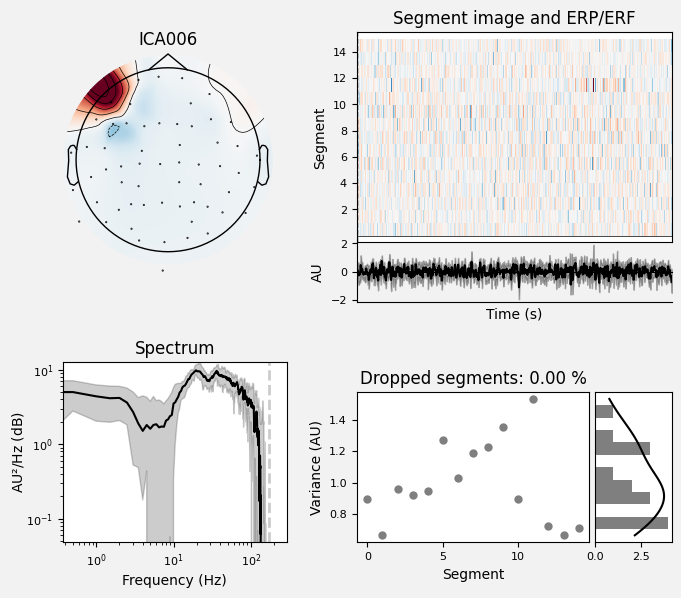

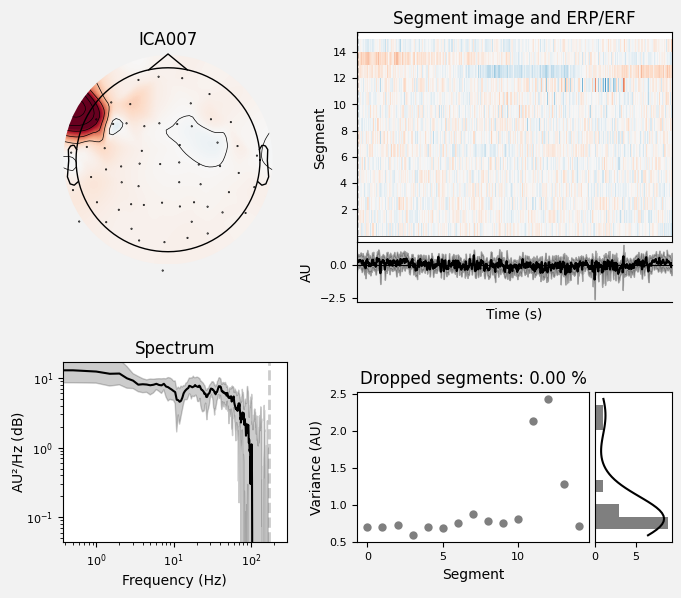

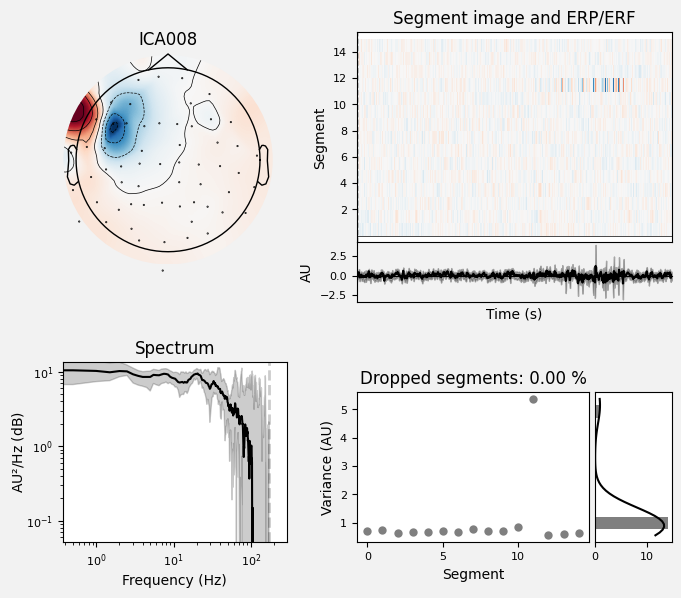

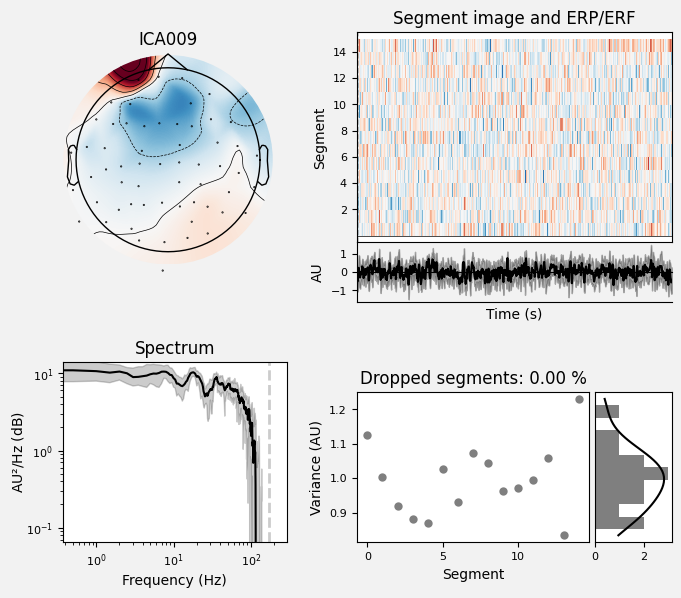

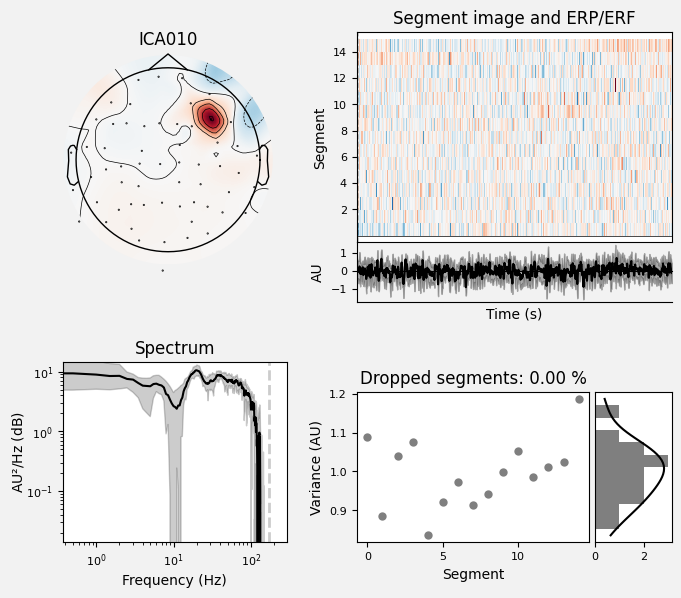

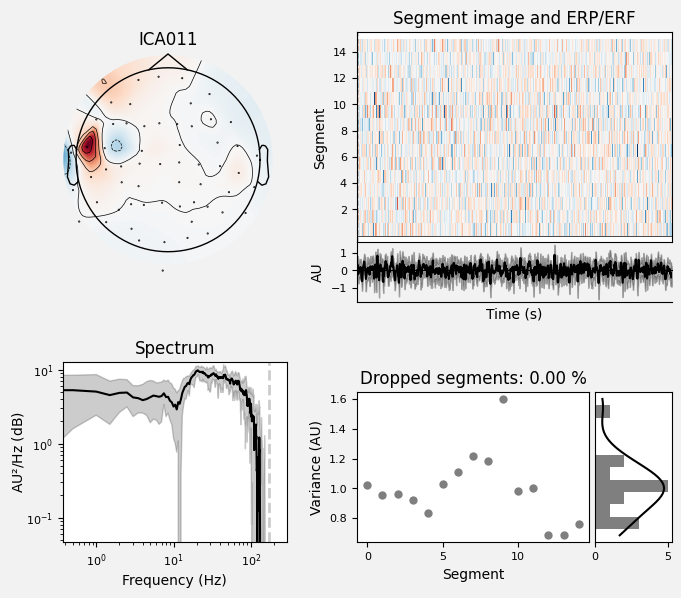

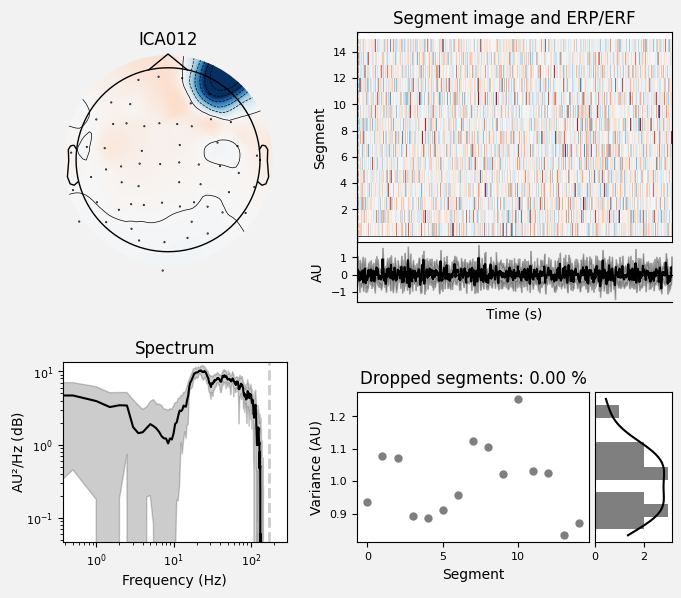

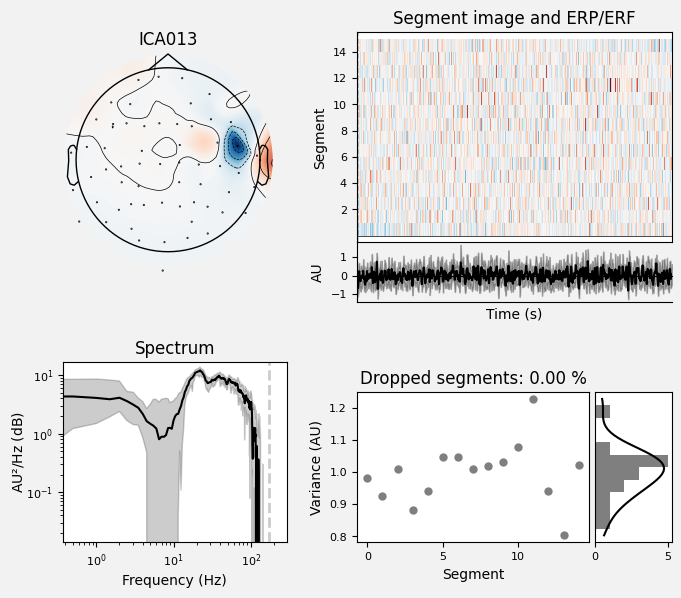

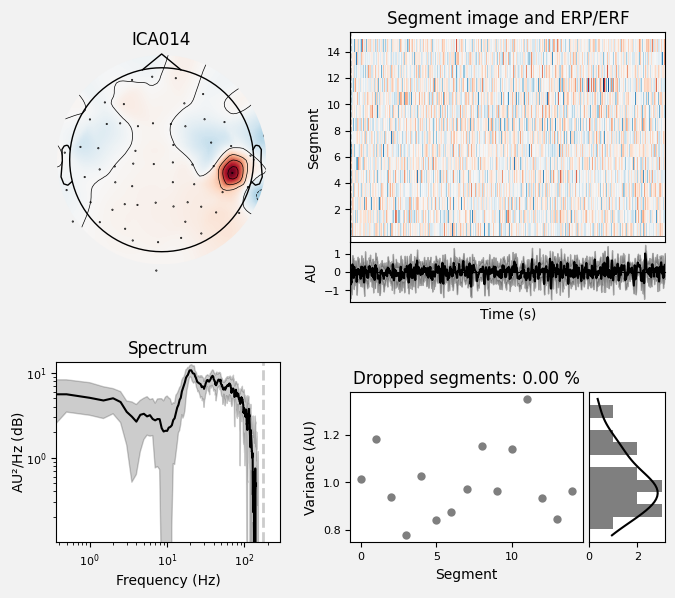

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 59 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components
    Projecting back using 59 PCA components


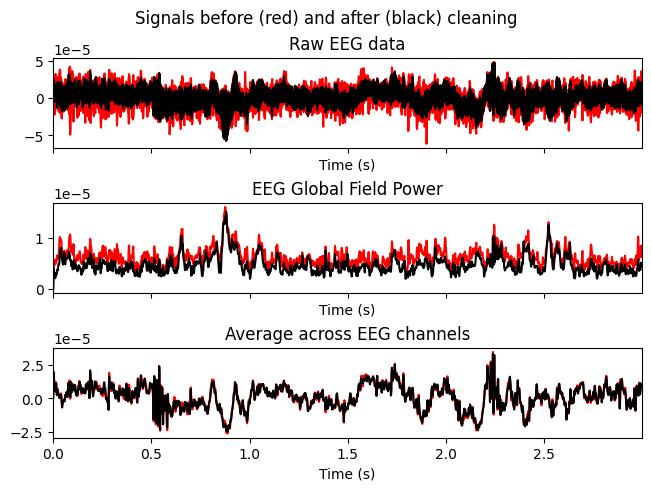

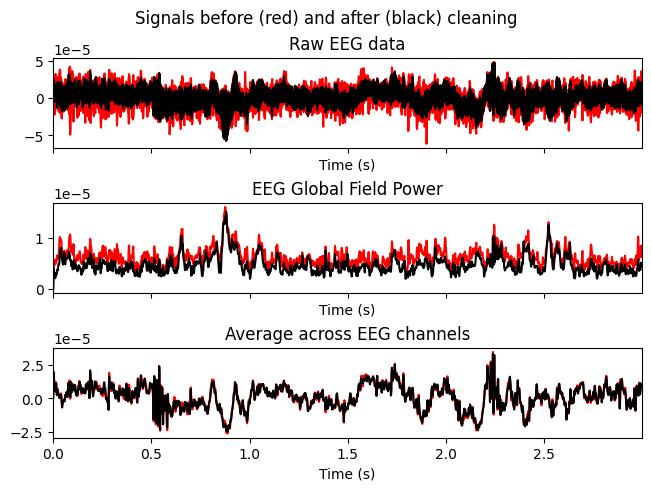

In [10]:
muscle_idx = [6, 7, 8, 9, 10, 11, 12, 13, 14]
ica.plot_properties(raw, picks=muscle_idx, log_scale=True)

# first, remove blinks and heartbeat to compare
blink_idx = [0]
heartbeat_idx = [5]
ica.apply(raw, exclude=blink_idx + heartbeat_idx)
ica.plot_overlay(raw, exclude=muscle_idx)

Finally, let's try an automated algorithm to find muscle components
and ensure that it gets the same components we did manually.



Effective window size : 3.410 (s)


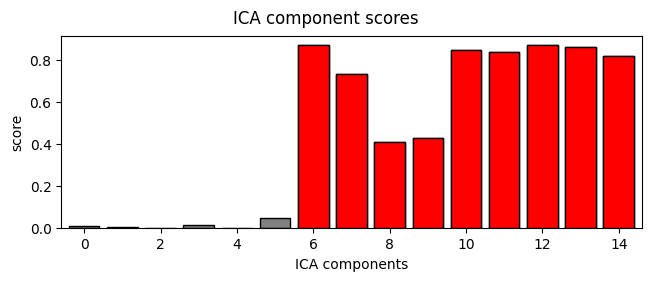

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [6, 7, 8, 9, 10, 11, 12, 13, 14]


In [11]:
muscle_idx_auto, scores = ica.find_bads_muscle(raw)
ica.plot_scores(scores, exclude=muscle_idx_auto)
print(
    f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
    f"Automatically found muscle artifact ICA components: {muscle_idx_auto}"
)

## Let's now replicate this on the EEGBCI dataset



Download complete in 05m19s (1.2 MB)
Extracting EDF parameters from C:\Users\ABC\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA took 1.0s.
Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


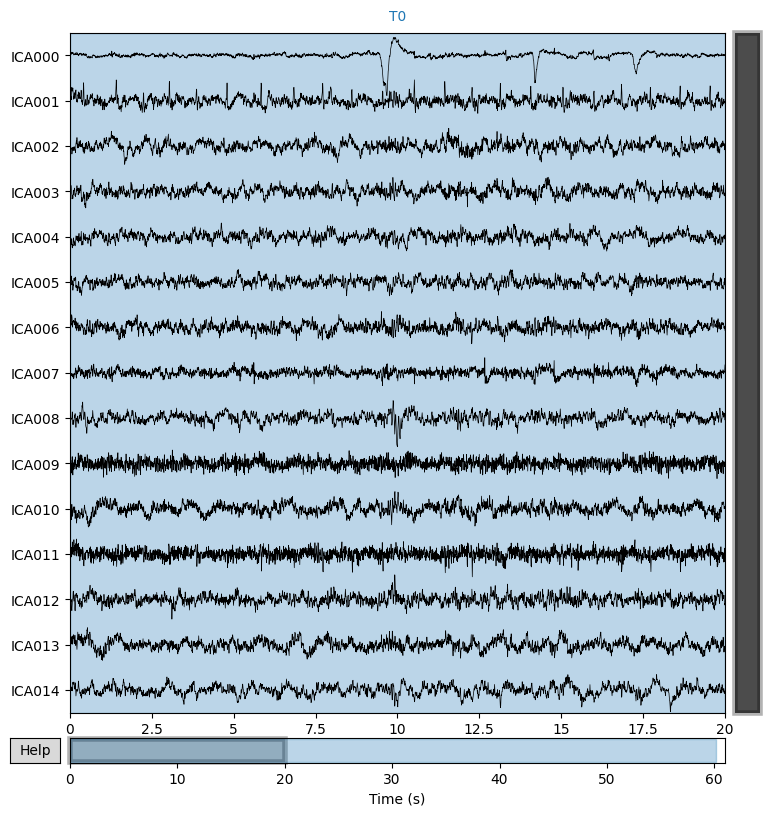

Effective window size : 12.800 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


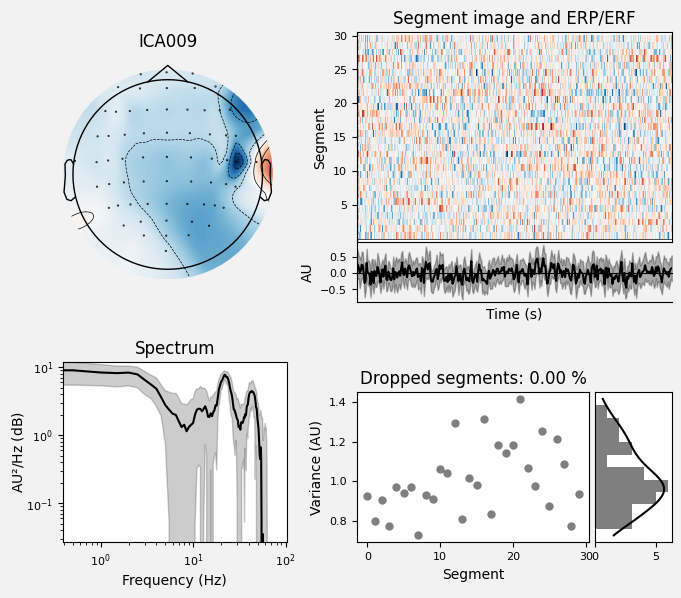

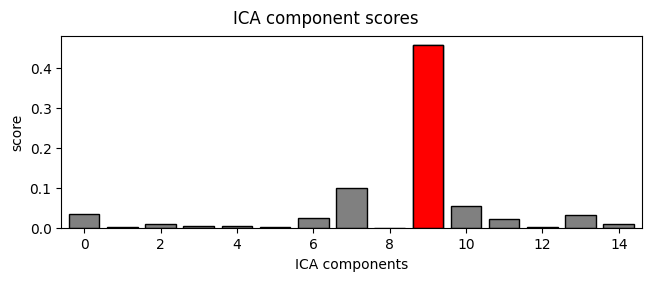

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [9]


Download complete in 06s (1.2 MB)
Extracting EDF parameters from C:\Users\ABC\mne_data\MNE-eegbci-data\files\eegmmidb\1.0.0\S002\S002R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 529 samples (3.306 s)

Fitting ICA to data using 64 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 15 components
Fitting ICA took 1.1s.
Creating RawArray with float64 data, n_channels=15, n_times=9760
    Range : 0 ... 9759 =      0.000 ...    60.994 secs
Ready.


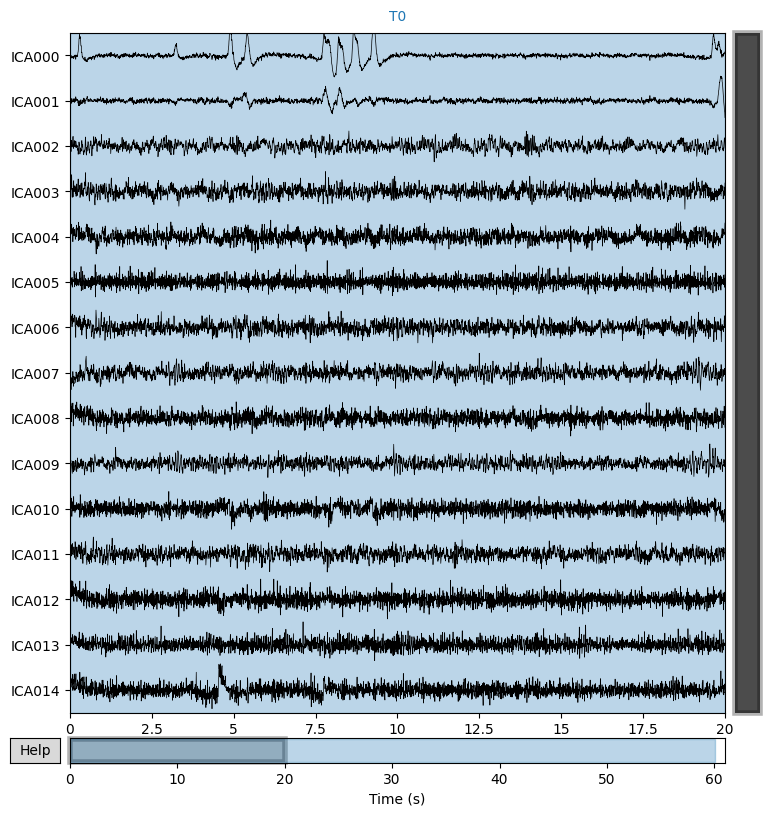

Effective window size : 12.800 (s)
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated


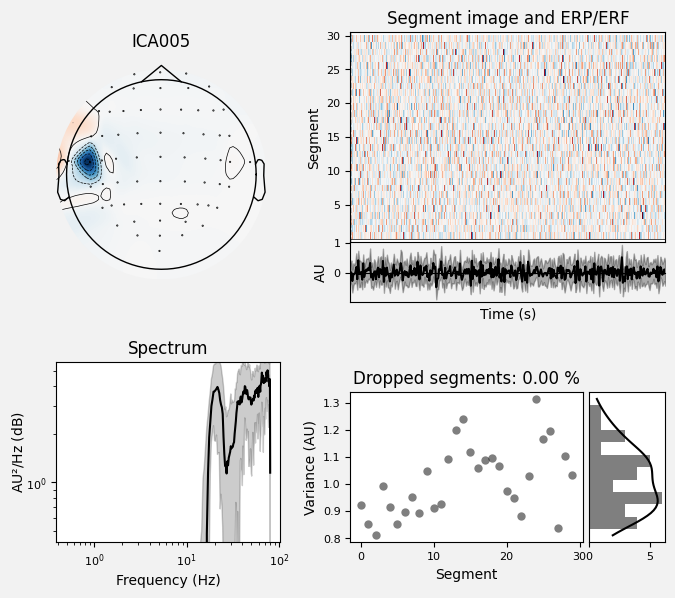

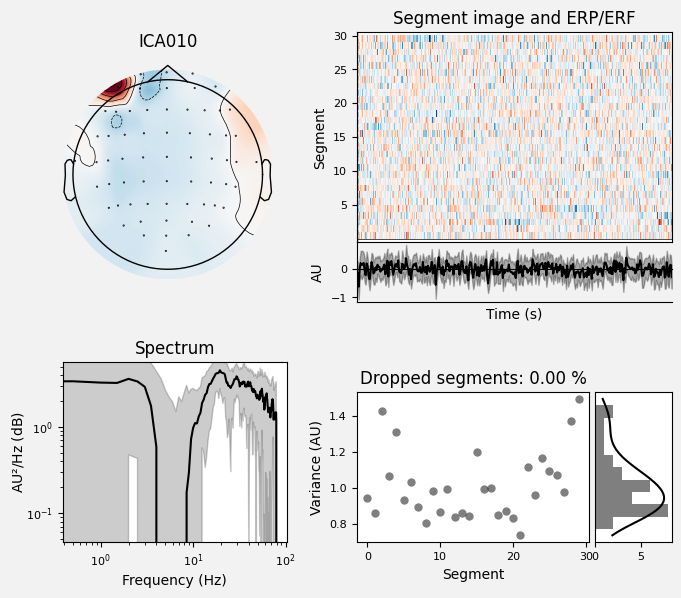

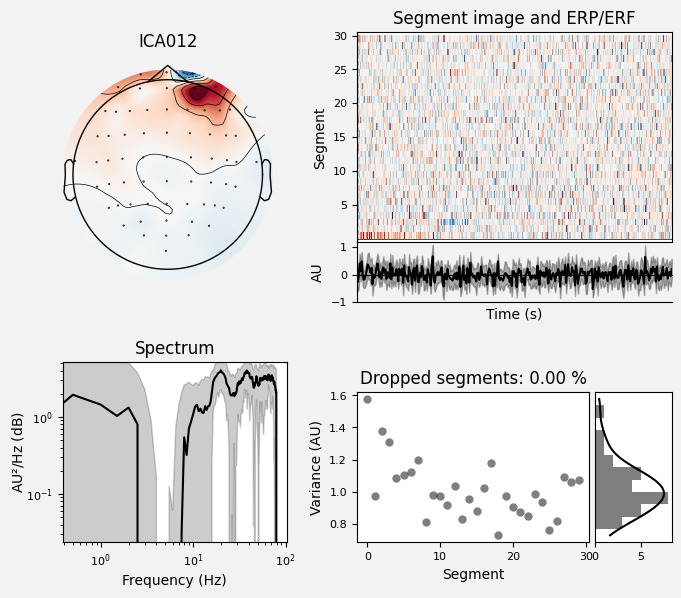

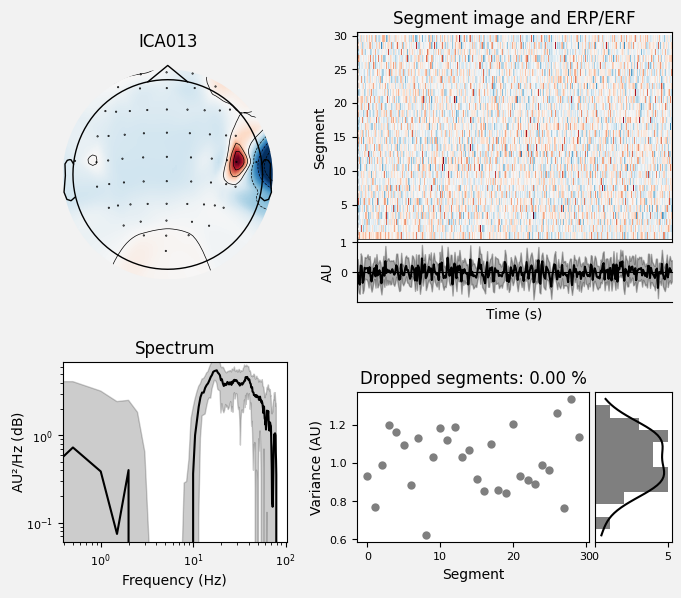

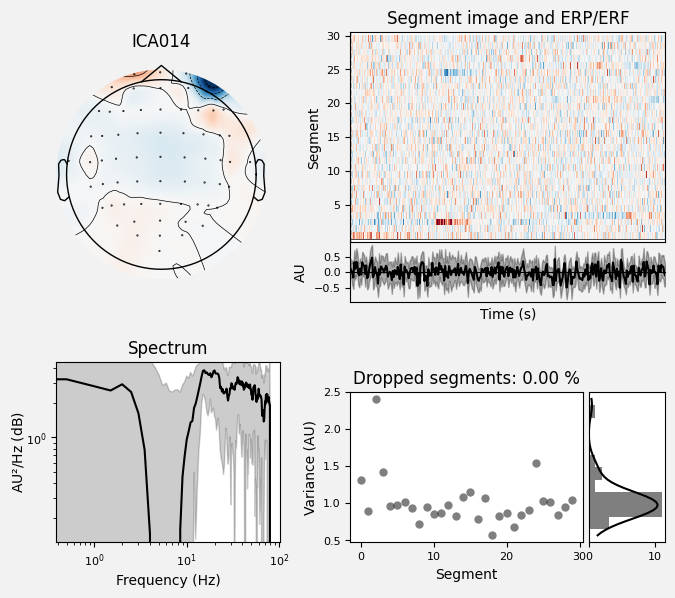

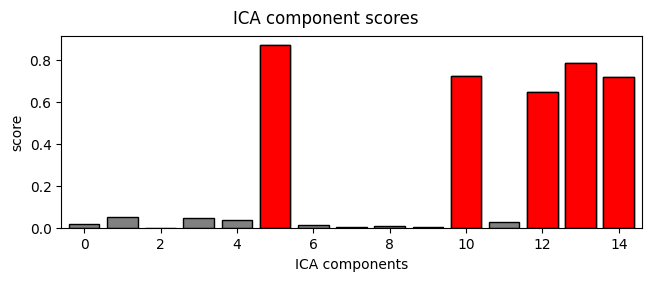

Manually found muscle artifact ICA components:      [6, 7, 8, 9, 10, 11, 12, 13, 14]
Automatically found muscle artifact ICA components: [5, 10, 12, 13, 14]


In [12]:
for sub in (1, 2):
    raw = mne.io.read_raw_edf(
        mne.datasets.eegbci.load_data(subject=sub, runs=(1,))[0], preload=True
    )
    mne.datasets.eegbci.standardize(raw)  # set channel names
    montage = mne.channels.make_standard_montage("standard_1005")
    raw.set_montage(montage)
    raw.filter(l_freq=1.0, h_freq=None)

    # Run ICA
    ica = mne.preprocessing.ICA(
        n_components=15, method="picard", max_iter="auto", random_state=97
    )
    ica.fit(raw)
    ica.plot_sources(raw)
    muscle_idx_auto, scores = ica.find_bads_muscle(raw)
    ica.plot_properties(raw, picks=muscle_idx_auto, log_scale=True)
    ica.plot_scores(scores, exclude=muscle_idx_auto)

    print(
        f"Manually found muscle artifact ICA components:      {muscle_idx}\n"
        "Automatically found muscle artifact ICA components: "
        f"{muscle_idx_auto}"
    )

## References
.. footbibliography::

